# Emulator Setup

In [1]:
# %matplotlib widget

In [40]:
# modified from test.ipynb and main.py

from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

In [41]:
# Libraries for multiprocessing
from multiprocess.pool import Pool
from tqdm import tqdm

In [42]:
from loop import *

## miniSCOT Functions

In [65]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336,
        'num_batteries': int(x[0])
    }

    if len(x) == 2:
        kwargs.update({
            'battery_penalty': int(x[1])
        })

    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [86]:
def f(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    Y = []
    for x in X:
        cum_reward = invoke_miniscot(x)

        # Note that we negate the reward; want to find min
        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [87]:
def f_multiprocess(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs using multiprocessing.

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    
    # Set to None to use all available CPU
    max_pool = 4
    with Pool(max_pool) as p:
        Y = list(
            tqdm(
                p.imap(invoke_miniscot, X),
                total=X.shape[0]
            )
        )

    # Note that we negate the reward; want to find min
    Y = -np.reshape(np.array(Y), (-1, 1))
    return Y

## Plotting Functions

In [88]:
def plot_reward(X, Y, labels):
    """
    Plots reward against a maximum of two dimensions.
    """

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(10,10))

    order = np.argsort(X[:,0])
    
    if X.shape[1] == 1:
        ax = plt.axes()
        ax.plot(X[order,0], Y[order])
        ax.set_xlabel(labels[0])
        ax.set_ylabel("Cumulative reward")
    elif X.shape[1] == 2:
        ax = plt.axes(projection='3d')
        im = ax.plot_trisurf(X[order,0].flatten(), X[order,1].flatten(), Y[order].flatten(), cmap=cm.get_cmap('autumn'))
        fig.colorbar(im)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel("Cumulative reward")
    else:
        raise ValueError('X has too many dimensions to plot - max 2 allowed')

    return fig, ax

## Investigation Parameter Space

In [91]:
max_num_batteries = 1000
min_battery_capacity = 50
max_battery_capacity = 150
min_battery_penalty = -(25 * 1000)
max_battery_penalty = -(250 * 1000)
num_data_points = 20

timsteps_per_week = 336
num_weeks = 4

In [92]:
num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1, 10))
battery_penalty = DiscreteParameter('battery_penalty', range(max_battery_penalty, min_battery_penalty))
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

# parameter_space = ParameterSpace([num_batteries])
parameter_space = ParameterSpace([num_batteries, battery_penalty])

design = RandomDesign(parameter_space)

X = design.get_samples(num_data_points)
X

array([[    374,  -40638],
       [    796,  -65777],
       [    467, -194818],
       [     26,  -98607],
       [    485,  -33698]])

## Emukit Bayesian Optimisation

### Get Initial Points and Plot Them

The same code appears at the top of the Emukit cell below. Optionally run this to check whether we get a convex function.

In [114]:
Y = f_multiprocess(X)

  0%|                                                                                                                                                                               | 0/5 [00:00<?, ?it/s]


ValueError: Action quantity is negative, which is not possible!

(<Figure size 720x720 with 2 Axes>,
 <Axes3DSubplot:xlabel='num_batteries', ylabel='max_battery_capacity'>)

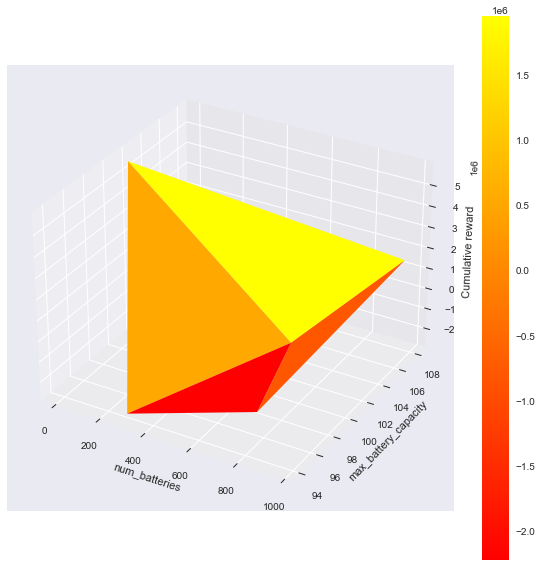

In [51]:
plot_reward(X, Y, parameter_space.parameter_names)

### Step Through Emulator Acquiring New Points Until Convergence

In [ ]:
def run_emulator():

    successful_sample = False
    num_tries = 0
    max_num_tries = 3

    use_default= False
    use_ard=False

    while not successful_sample and num_tries < max_num_tries: 

        print(f"CURRENT ATTEMPT #{num_tries}")

        # emulator model

        if use_default: 
            gpy_model = GPRegression(X, Y)
        else: 
            kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
            gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)

        try: 
            gpy_model.optimize()
            print("okay to optimize")
            model_emukit = GPyModelWrapper(gpy_model)

            # Load core elements for Bayesian optimization
            expected_improvement = ExpectedImprovement(model=model_emukit)
            optimizer = GradientAcquisitionOptimizer(space=parameter_space)

            # Create the Bayesian optimization object
            batch_size = 3
            bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                     space=parameter_space,
                                                     acquisition=expected_improvement,
                                                     batch_size=batch_size)

            # Run the loop and extract the optimum;  we either complete 10 steps or converge
            max_iters = 5
            stopping_condition = (
                FixedIterationsStoppingCondition(i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)
            )

            bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
            print("successfully ran loop")
            successful_sample = True

        except: 
            num_tries += 1

In [75]:
num_tries

0

In [76]:
# X, Y

In [77]:
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y

new_order = np.argsort(new_X[:,0])
new_X = new_X[new_order,:]
new_Y = new_Y[new_order]

# new_X, new_Y

## Visualize and Get Extrema

### Simple Plot

In [78]:
plot_reward(new_X, new_Y, parameter_space.parameter_names)

ValueError: X has too many dimensions to plot - max 2 allowed

<Figure size 720x720 with 0 Axes>

### 2D Plot

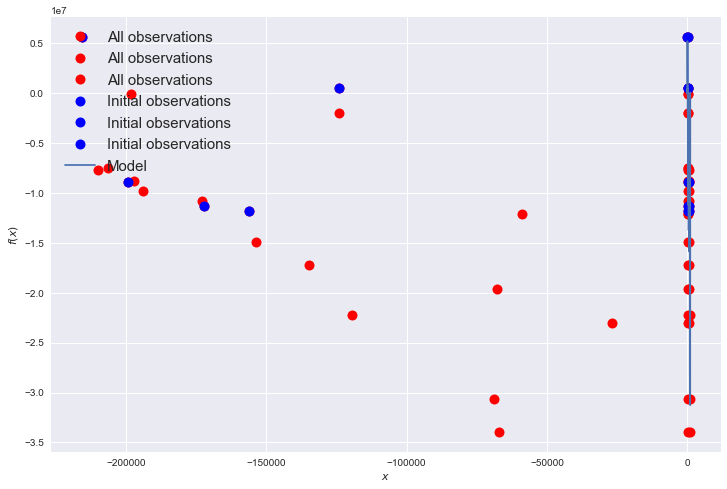

In [79]:
x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
#plt.figure(figsize=(7, 5))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
# plt.xlim(0, 25)
plt.show()

## 3D Plots

#### Inferred Surface

In [121]:
def plot_inferred_surface()

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    im = ax.plot_trisurf(new_X[:,0].flatten(), new_X[:,1].flatten(), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
    fig.colorbar(im)

    ax.scatter(X[:,0].flatten(), X[:,1].flatten(), Y.flatten(), s=100, marker="o", color="b", label="Initial observations")
    ax.scatter(new_X[:,0].flatten(), new_X[:,1].flatten(), new_Y.flatten(), marker="x", color="r", label="All observations")

    ax.legend(loc=2, prop={'size': LEGEND_SIZE})
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_ylabel(r"$f(x)$")
    ax.grid(True)

SyntaxError: invalid syntax (205145964.py, line 1)

#### Prediction Surface

In [80]:
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1, min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
mu_plot, var_plot = model_emukit.predict(positions)

ValueError: cannot reshape array of size 101000 into shape (1000,21)

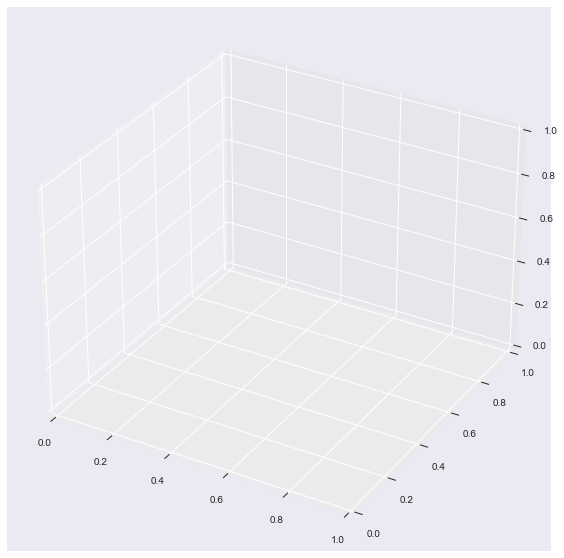

In [81]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape((1000,21)), cmap=cm.coolwarm,linewidth=0, antialiased=False)

## Old Code

In [22]:

# X = design.get_samples(num_data_points)
# Y = f(X)


In [23]:
# # emulator model
# use_default= False
# use_ard=True
# if use_default: 
#     gpy_model = GPRegression(X, Y)
# else: 
#     kernel = GPy.kern.RBF(1, lengthscale=1e1, variance=1e4, ARD=use_ard)
#     gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
# gpy_model.optimize()
# model_emukit = GPyModelWrapper(gpy_model)

In [24]:
# # Load core elements for Bayesian optimization
# expected_improvement = ExpectedImprovement(model=model_emukit)
# optimizer = GradientAcquisitionOptimizer(space=parameter_space)

In [25]:
# # Create the Bayesian optimization object
# batch_size = 3
# bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
#                                          space=parameter_space,
#                                          acquisition=expected_improvement,
#                                          batch_size=batch_size)


In [26]:
# # Run the loop and extract the optimum;  we either complete 10 steps or converge
# max_iters = 10
# stopping_condition = FixedIterationsStoppingCondition(
#     i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)

# bayesopt_loop.run_loop(f, stopping_condition)

# Global Sensitivity Analysis

In [129]:
import pandas as pd
import mlai.plot as plot
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

## Comparing Rel. Sensitivity of No. Batteries to Max Battery Capacities

In [142]:
max_num_batteries = 1000
min_battery_capacity = 50
max_battery_capacity = 150
min_battery_penalty = -(25 * 1000)
max_battery_penalty = -(250 * 1000)
num_data_points = 10

timsteps_per_week = 336
num_weeks = 52

In [143]:
num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1, 10))
battery_penalty = DiscreteParameter('battery_penalty', range(max_battery_penalty, min_battery_penalty))
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

# parameter_space = ParameterSpace([num_batteries])
parameter_space = ParameterSpace([num_batteries, max_battery_capacities])

design = RandomDesign(parameter_space)

X = design.get_samples(num_data_points)
X

array([[ 85,  50],
       [182, 140],
       [768,  90],
       [659, 120],
       [ 62,  90],
       [734,  70],
       [635, 130],
       [964,  60],
       [443,  60],
       [631, 100]])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.07s/it]


(<Figure size 720x720 with 2 Axes>,
 <Axes3DSubplot:xlabel='num_batteries', ylabel='max_battery_capacity'>)

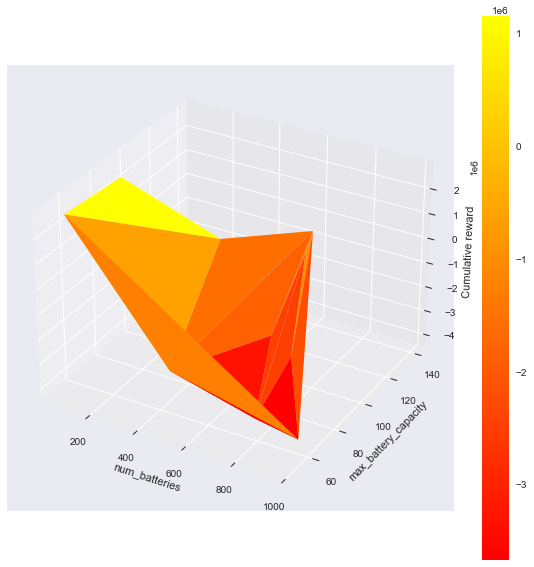

In [144]:
# Get initial points
Y = f_multiprocess(X)
plot_reward(X, Y, parameter_space.parameter_names)

In [137]:
# RUN EMULATOR
run_emulator()

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model


CURRENT ATTEMPT #0
okay to optimize


INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:01<00:00, 20.42s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optim

successfully ran loop


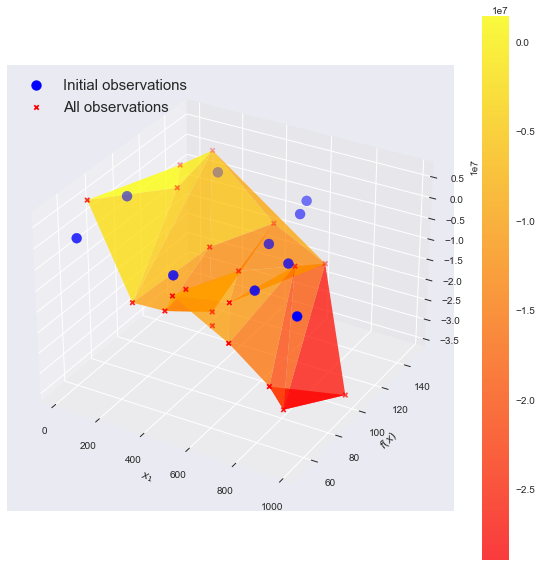

In [145]:
# PLOT INFERRED SURFACE

plt.style.use('seaborn')
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:,0].flatten(), new_X[:,1].flatten(), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:,0].flatten(), X[:,1].flatten(), Y.flatten(), s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:,0].flatten(), new_X[:,1].flatten(), new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)

In [154]:
num_mc = 10000
sensitivity = MonteCarloSensitivity(model = gpy_model, input_domain = parameter_space)
main_effects_gp, total_effects_gp, _ = sensitivity.compute_effects(num_monte_carlo_points = num_mc)

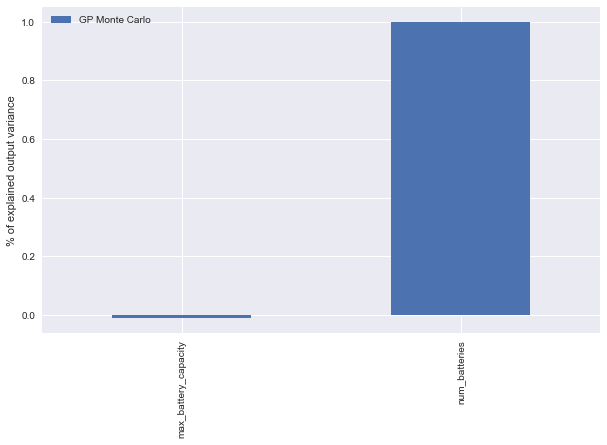

In [155]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

plt.show()

[]

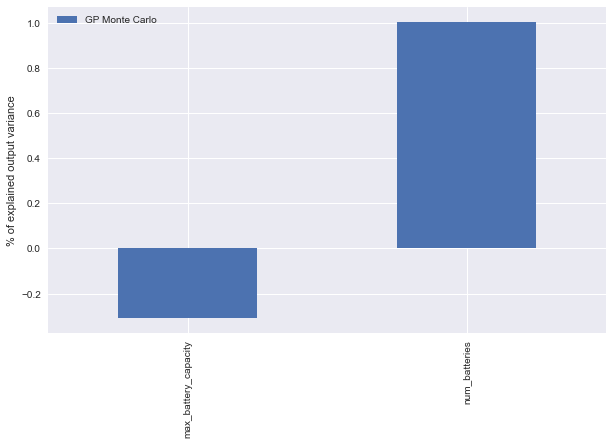

In [148]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

plt.plot()

# Analysing how Changing Battery Cost (Penalty) Changes The Recommended No. of Batteries

In [ ]:
max_num_batteries = 1000
min_battery_capacity = 50
max_battery_capacity = 150
min_battery_penalty = -(25 * 1000)
max_battery_penalty = -(250 * 1000)
num_data_points = 5

timsteps_per_week = 336
num_weeks = 4

In [136]:
num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1, 10))
battery_penalty = DiscreteParameter('battery_penalty', range(max_battery_penalty, min_battery_penalty))
time_horizon = DiscreteParameter('time_horizon', [i for i in range(0, num_weeks*timsteps_per_week, timsteps_per_week)])

parameter_space = ParameterSpace([num_batteries])
# parameter_space = ParameterSpace([num_batteries, battery_penalty])

design = RandomDesign(parameter_space)

X = design.get_samples(num_data_points)
X

array([[796],
       [792],
       [722],
       [969],
       [460],
       [496],
       [936],
       [372],
       [208],
       [376]])

In [ ]:
# Get initial points
Y = f_multiprocess(X)
plot_reward(X, Y, parameter_space.parameter_names)

In [ ]:
# RUN EMULATOR
run_emulator()

In [ ]:
plot_inferred_surface()